## Pepper Disease Detection using CNN

Dataset from https://www.kaggle.com/arjuntejaswi/plant-village

In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

In [35]:
df = tf.keras.preprocessing.image_dataset_from_directory(
        '/home/larissa/Pepper',shuffle=True, image_size=(256,256),batch_size= 32)

Found 2475 files belonging to 3 classes.


In [36]:
image_size = 256
Batch_size = 32
rgb_chanels = 3
epochs = 30

In [37]:
class_names = df.class_names
class_names

['.ipynb_checkpoints',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy']

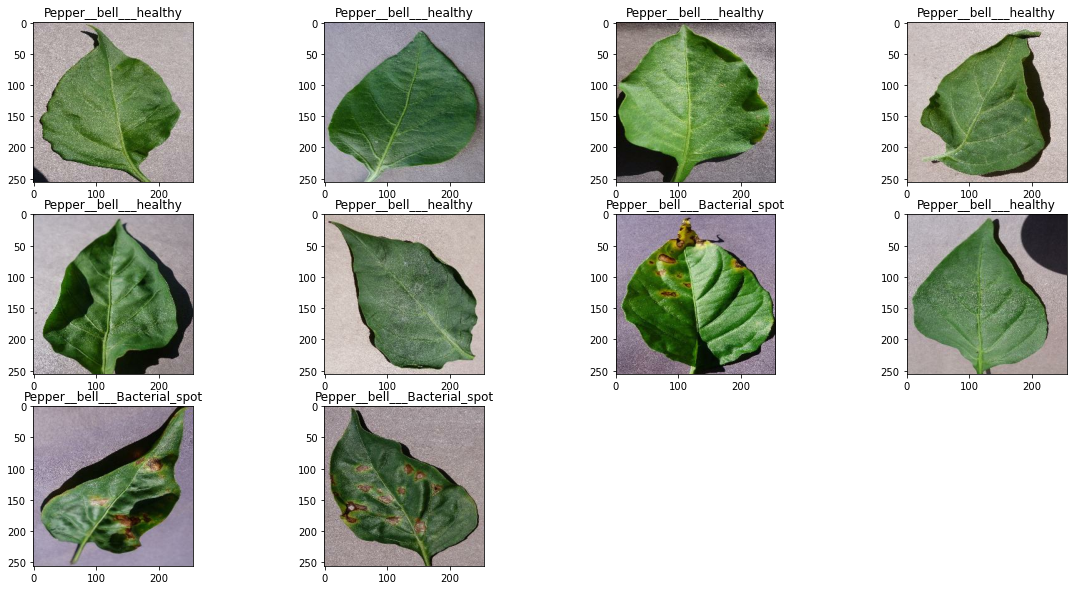

In [38]:
plt.figure(figsize=(20,10))
for image_batch, label_batch in df.take(1):
    for i in range(10):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

80% training, 10% val, 10% test

In [39]:
def data_part(df,train_split = 0.8, val_split = 0.1, test_split = 0.1,shuffle = True,shuffle_size = 1000):
    df_size = len(df)
    if shuffle:
        df = df.shuffle(shuffle_size,seed = 420)
    train_size = int(train_split*df_size)
    val_size = int(val_split*df_size)
    test_size  = int(test_split*df_size)
    
    train_df = df.take(train_size)
    
    val_df = df.skip(train_size).take(val_size)
    
    test_df = df.skip(train_size).skip(val_size)
    

    return train_df,val_df, test_df

In [40]:
train,val,test = data_part(df)

In [41]:
len(train), len(val), len(test), len(df)

(62, 7, 9, 78)

In [42]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# load and train : GPU and CPU

In [43]:
#Layer for Resizing and Normalization

rescale = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(image_size,image_size),
    keras.layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

data_augmentation = tf.keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [44]:
train = train.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [45]:
input_shape_all = (Batch_size,image_size,image_size,rgb_chanels)
n_classes = len(class_names)

In [46]:
model = keras.Sequential([
    rescale,
    keras.layers.Conv2D(42, kernel_size = (3,3), activation='relu', input_shape=input_shape_all),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(80,  kernel_size = (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(80,  kernel_size = (3,3), activation='relu'),
    
    keras.layers.Flatten(),
    keras.layers.Dense(80, activation='relu'),
    keras.layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape_all)

In [47]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_13 (Conv2D)          (32, 254, 254, 42)        1176      
                                                                 
 max_pooling2d_10 (MaxPoolin  (32, 127, 127, 42)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 125, 125, 80)        30320     
                                                                 
 max_pooling2d_11 (MaxPoolin  (32, 62, 62, 80)         0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (32, 60, 60, 80)         

In [48]:
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=["accuracy"])

history = model.fit(
train, epochs=epochs, batch_size=Batch_size, verbose=1, validation_data=val)

Epoch 1/30
62/62 [==============================] - 18s 270ms/step - loss: 0.8722 - accuracy: 0.7152 - val_loss: 0.2619 - val_accuracy: 0.9062
Epoch 2/30
62/62 [==============================] - 15s 248ms/step - loss: 0.3049 - accuracy: 0.9068 - val_loss: 0.3003 - val_accuracy: 0.8973
Epoch 3/30
62/62 [==============================] - 14s 230ms/step - loss: 0.2053 - accuracy: 0.9415 - val_loss: 0.1818 - val_accuracy: 0.9420
Epoch 4/30
62/62 [==============================] - 15s 239ms/step - loss: 0.1611 - accuracy: 0.9491 - val_loss: 0.1241 - val_accuracy: 0.9554
Epoch 5/30
62/62 [==============================] - 27s 437ms/step - loss: 0.1549 - accuracy: 0.9516 - val_loss: 0.1387 - val_accuracy: 0.9464
Epoch 6/30
62/62 [==============================] - 22s 356ms/step - loss: 0.1224 - accuracy: 0.9607 - val_loss: 0.0855 - val_accuracy: 0.9554
Epoch 7/30
62/62 [==============================] - 19s 299ms/step - loss: 0.1491 - accuracy: 0.9561 - val_loss: 0.0998 - val_accuracy: 0.9732

In [49]:
scores = model.evaluate(test)
print(f"Test Accuracy: {round(scores[1],3)*100}%")

9/9 [==============================] - 1s 39ms/step - loss: 0.0350 - accuracy: 0.9896
Test Accuracy: 99.0%


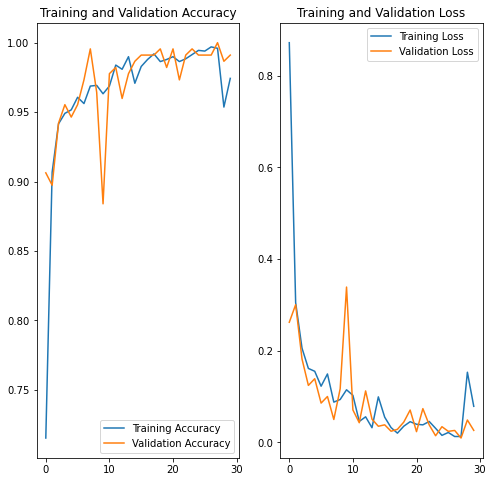

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence



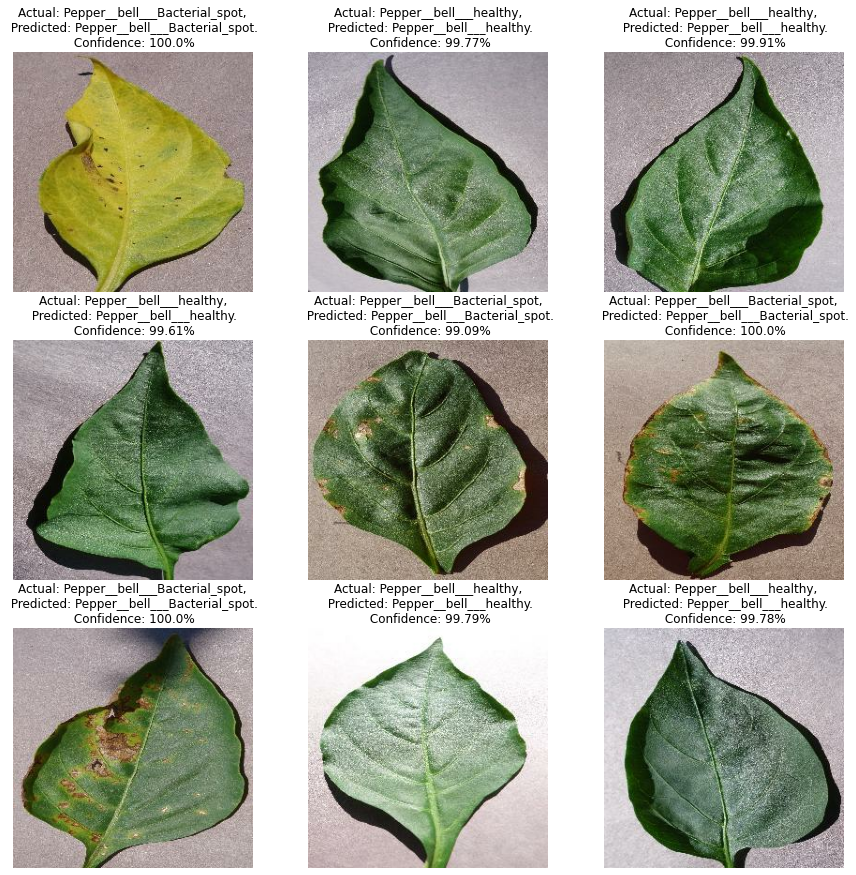

In [52]:
plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

